# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [1]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-09-27 10:08:26.682629: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 10:08:26.740161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 10:08:28.702477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Callable, Sequence, Union
import numpy as np
from fastcore.xtras import Path
import pandas as pd
import cv2

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

## Load the data

In [4]:
dst = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013/")

In [5]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-4,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "USE_BIAS": False,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false

In [6]:
# wandb.init(project="CLIC2024_IQA",
#            name="PerceptNet_GaborLast",
#            job_type="evaluation",
#            config=config,
#            mode="online",
#            )
# config = config
config

BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false

In [7]:
dst_rdy = dst.dataset.batch(config.BATCH_SIZE, drop_remainder=False)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [8]:
class GDN(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    # feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        denom = nn.Conv(features=inputs.shape[-1], # Same output channels as input
                        kernel_size=self.kernel_size if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                        strides=self.strides, 
                        padding=self.padding,
                        # feature_group_count=self.feature_group_count,
                        feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                        kernel_init=self.kernel_init, 
                        bias_init=self.bias_init)(inputs**self.alpha)
        # denom = nn.relu(denom)
        return inputs / (denom**self.epsilon + self.eps)

In [58]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        ## Include normalized GDN
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME")(outputs) # J&H
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(outputs) # apply_independently=True
        ## Center-Surround
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        # outputs = GaborLayer(features=128, kernel_size=21, strides=1, padding="SAME", fs=21, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=config.USE_BIAS)(outputs, **kwargs)
        outputs = GaborLayer_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=64, fs=64, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=config.USE_BIAS)(outputs, **kwargs)
        # outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

In [ ]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        # outputs = GaborLayer(features=128, kernel_size=21, strides=1, padding="SAME", fs=21, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=config.USE_BIAS)(outputs, **kwargs)
        outputs = GaborLayer_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=64, fs=64, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=config.USE_BIAS)(outputs, **kwargs)
        # outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [10]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [11]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [12]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Load the pretrained the model!

In [59]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [60]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [61]:
state = orbax_checkpointer.restore("model-best", item=state)

## Evaluate the model!

In [62]:
@jax.jit
def forward_pass(state, img):
    pred, updated_state = state.apply_fn({"params": state.params, **state.state}, img, mutable=list(state.state.keys()), train=False)
    return pred

In [63]:
@jax.jit
def compute_distance(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    if len(img.shape) == 3:
        img = img[None,:]
        img_dist = img_dist[None,:]
    ## Forward pass through the model
    img_pred, updated_state = state.apply_fn({"params": state.params, **state.state}, img, mutable=list(state.state.keys()), train=False)
    img_dist_pred, updated_state = state.apply_fn({"params": state.params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

    ## Calculate the distances
    dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
    
    return dist

In [64]:
from tqdm.auto import tqdm

We'll obtain the transformation of all the images to analyze their highest activations with regards to frequency, orientations and phase:

In [65]:
def obtain_activations_module(activation):
    return jnp.mean(activation**2, axis=(0,1))

In [66]:
%%time
raw_outputs_0, outputs_0, raw_outputs_1, outputs_1 = [], [], [], []
for batch in tqdm(dst_rdy.as_numpy_iterator(), total=len(dst_rdy)):
    ## 1. Obtain the transformations of the images
    pred_0 = forward_pass(state=state, img=batch[0])
    pred_1 = forward_pass(state=state, img=batch[1])

    raw_outputs_0.extend(pred_0)
    raw_outputs_1.extend(pred_1)

    ## 2. Calculate the (mean) activations module per channel
    pred_0 = jax.vmap(obtain_activations_module)(pred_0)
    pred_1 = jax.vmap(obtain_activations_module)(pred_1)

    ## 3. Store the results
    outputs_0.extend(pred_0)
    outputs_1.extend(pred_1)
    break

outputs_0 = jnp.array(outputs_0)
outputs_1 = jnp.array(outputs_1)
raw_outputs_0 = jnp.array(raw_outputs_0)
raw_outputs_1 = jnp.array(raw_outputs_1)

  0%|          | 0/47 [00:00<?, ?it/s]

CPU times: user 4 s, sys: 806 ms, total: 4.81 s
Wall time: 901 ms


In [67]:
import matplotlib.pyplot as plt

In [68]:
probs, bines = [], []
for i in range(4):
    prob, bins = jnp.histogram(raw_outputs_0[0][:,:,i].ravel(), 
                                bins=int(jnp.sqrt(len(raw_outputs_0[0][:,:,i].ravel()))),
                                density=True)
    probs.append(prob)
    bines.append(bins)

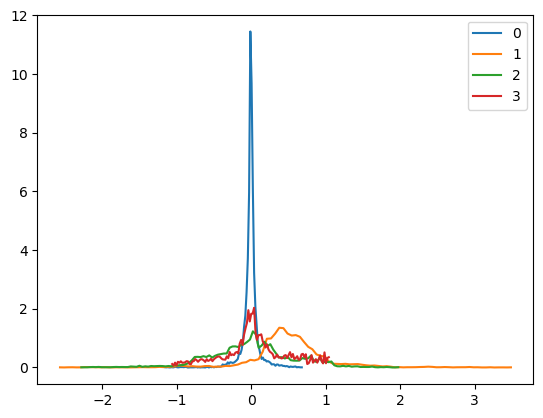

In [69]:
for i, (prob, bins) in enumerate(zip(probs, bines)):
        plt.plot(bins[:-1],
                prob,
                label=i)
plt.legend()
# plt.yscale("log")
plt.show()

In [79]:
updated_state["intermediates"]["GaborLayer__0"]["__call__"][0].shape

(64, 96, 128, 64)

In [125]:
%%time
gabor_output_0, gdn_output_0 = [], []
for batch in tqdm(dst_rdy.as_numpy_iterator(), total=len(dst_rdy)):
    ## 1. Obtain the transformations of the images
    pred, updated_state = state.apply_fn({"params": state.params, **state.state}, batch[0], mutable=list(state.state.keys()), train=False, capture_intermediates=True)

    ## 2. Store the results
    gabor_output_0.extend(batch[0])
    gdn_output_0.extend(updated_state["intermediates"]["GDN_0"]["__call__"][0])
    break

gabor_output_0 = jnp.array(gabor_output_0)
gdn_output_0 = jnp.array(gdn_output_0)

  0%|          | 0/47 [00:00<?, ?it/s]

CPU times: user 2.71 s, sys: 710 ms, total: 3.42 s
Wall time: 422 ms


In [101]:
(-state.params["GDN_3"]["Conv_0"]["kernel"][0,0,:,5]).argsort()

array([40,  8, 15,  3,  6, 47, 35, 38, 11,  7, 51, 31, 50, 18, 43, 37, 61,
       39, 60, 41, 42, 44, 45, 57, 56, 48, 49, 36, 52, 58, 53, 54, 55, 46,
       59,  0, 33,  1,  2,  4,  5,  9, 10, 12, 13, 14, 16, 17, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 62, 32, 34, 63])

In [105]:
params[8]

{'phase': 0.0, 'rot': 40.12468052457568, 'freq': 23.69595}

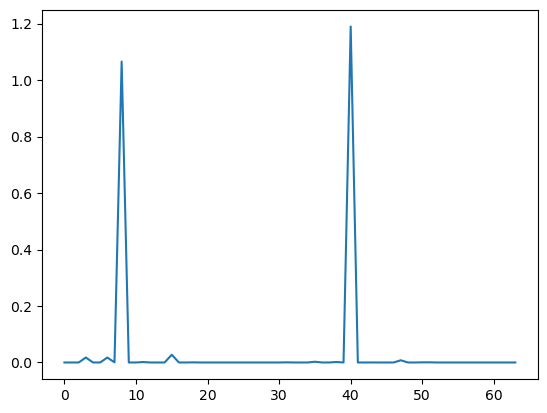

In [100]:
plt.plot(state.params["GDN_3"]["Conv_0"]["kernel"][0,0,:,5])
plt.show()

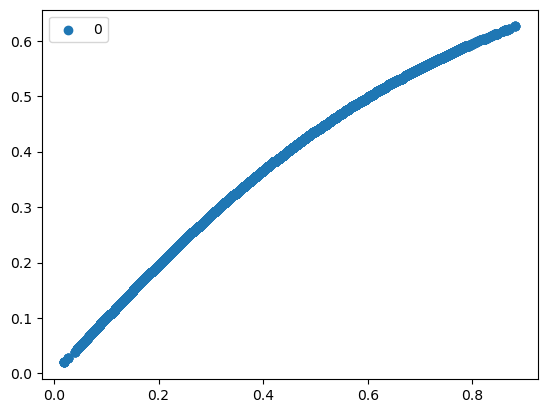

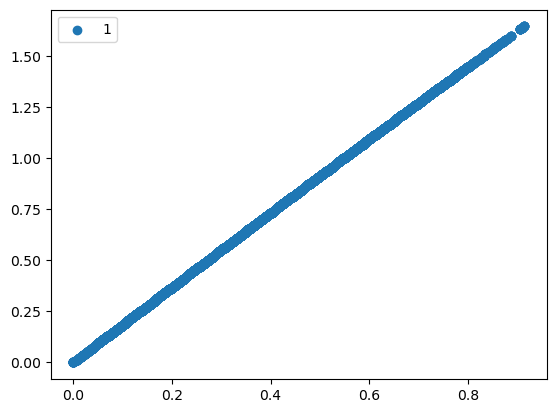

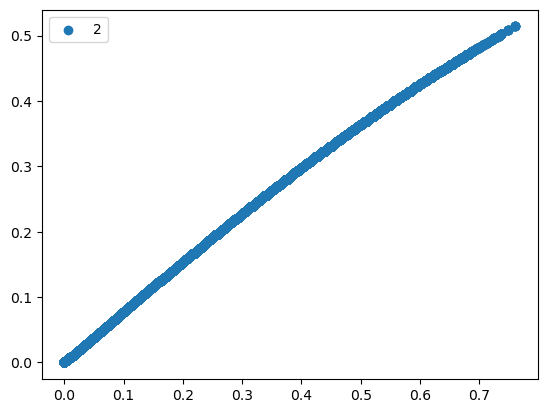

In [129]:
for i in range(3):
    plt.scatter(gabor_output_0[0:5,:,:,i].ravel(), gdn_output_0[0:5,:,:,i].ravel(), label=i)
    plt.legend()
    plt.show()

In [112]:
from einops import rearrange

In [122]:
state.params["GDN_0"]

FrozenDict({
    Conv_0: {
        bias: array([0.99056417, 0.296723  , 1.6603811 ], dtype=float32),
        kernel: array([[[[1.2806937 , 0.01465351, 0.91810834]]]], dtype=float32),
    },
})

In [169]:
outputs_0_r = rearrange(outputs_0, "n (phases rots fs_sigmas) -> n  phases (rots fs_sigmas)", phases=2, rots=8, fs_sigmas=4)
outputs_0_r.shape

(3000, 2, 32)

In [170]:
import matplotlib.pyplot as plt

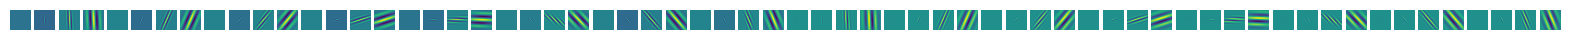

In [171]:
fig, axes = plt.subplots(1,64, figsize=(20,4))
for k, ax in zip(state.state["precalc_filter"]["GaborLayer__0"]["kernel"][:,:,0,:].transpose(2,0,1), axes):
    ax.imshow(k)
    ax.axis("off")
plt.show()

In [172]:
(-outputs_1[0]).argsort()

Array([51, 19, 35,  3,  2, 34, 15, 47, 18, 50, 39,  7,  1,  5, 63, 17, 33,
       31, 25, 43, 11, 13, 49, 59, 27, 55, 23,  9, 48, 46, 14, 16, 32, 45,
        0, 42, 37, 10, 29,  6, 38, 41, 30, 62, 58, 44, 12, 54, 22, 26, 57,
       61, 21, 53, 40,  8, 36,  4, 60, 28, 52, 20, 56, 24], dtype=int32)

In [103]:
params = []
phases = [0., 90.]
rots = state.params["GaborLayer__0"]["theta"]
freqs = state.params["GaborLayer__0"]["freq"]
for phase in phases:
    for rot in rots:
        for freq in freqs:
            params.append({"phase": phase, "rot": rot*180/jnp.pi, "freq": freq})
params = np.array(params)

In [174]:
params[(-outputs_1[0]).argsort()][:6]

array([{'phase': 90.0, 'rot': 92.2080865499274, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': 92.2080865499274, 'freq': 3.1530545},
       {'phase': 90.0, 'rot': -2.060268506526401, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': -2.060268506526401, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': -2.060268506526401, 'freq': 6.715935},
       {'phase': 90.0, 'rot': -2.060268506526401, 'freq': 6.715935}],
      dtype=object)

In [175]:
df_params = pd.DataFrame.from_dict({"phase":[d["phase"] for d in params],
                                    "rot":[d["rot"] for d in params],
                                    "freq":[d["freq"] for d in params]})
print(df_params.shape)
df_params.head()

(64, 3)


,phase,rot,freq
0,0.0,-2.060269,23.695950
1,0.0,-2.060269,12.327524
2,0.0,-2.060269,6.715935
3,0.0,-2.060269,3.153054
4,0.0,23.840330,23.695950


In [176]:
names = [f"p_{t.phase:.0f}_r_{t.rot:.0f}_f_{t.freq:.0f}" for t in df_params.itertuples()]
names[:2]

['p_0_r_-2_f_24', 'p_0_r_-2_f_12']

In [177]:
df_o1 = pd.DataFrame(outputs_1, columns=names)
df_o1.head()

,p_0_r_-2_f_24,p_0_r_-2_f_12,p_0_r_-2_f_7,p_0_r_-2_f_3,p_0_r_24_f_24,p_0_r_24_f_12,p_0_r_24_f_7,p_0_r_24_f_3,p_0_r_40_f_24,p_0_r_40_f_12,...,p_90_r_137_f_7,p_90_r_137_f_3,p_90_r_139_f_24,p_90_r_139_f_12,p_90_r_139_f_7,p_90_r_139_f_3,p_90_r_157_f_24,p_90_r_157_f_12,p_90_r_157_f_7,p_90_r_157_f_3
0,0.294233,3.531512,7.697433,33.553158,0.064564,2.258268,0.260744,3.609977,0.069937,0.577366,...,0.138679,1.448777,0.020355,0.112380,0.146664,1.751690,0.029313,0.108851,0.168078,2.218402
1,0.291123,3.461449,7.504765,32.955482,0.065818,2.244750,0.241159,3.411765,0.067774,0.576583,...,0.131067,1.360948,0.018611,0.110298,0.137609,1.645582,0.028355,0.103447,0.173820,2.076585
2,0.273432,3.400970,7.405616,32.390770,0.065515,2.245361,0.250069,3.171783,0.072659,0.568456,...,0.137590,1.343420,0.021327,0.108037,0.142038,1.618438,0.028553,0.101197,0.162274,1.988937
3,0.261650,3.320322,7.215115,32.207241,0.063091,2.209054,0.236551,2.752803,0.066400,0.554785,...,0.114653,1.275437,0.020675,0.103090,0.131016,1.539258,0.027794,0.100690,0.169904,1.883608
4,0.247265,3.194813,7.197233,30.783924,0.060429,2.157529,0.202038,2.645548,0.073312,0.534981,...,0.106598,1.197255,0.022283,0.101604,0.122310,1.456928,0.027649,0.092310,0.138744,1.783455


In [178]:
df_dst_o1 = pd.concat([dst.data, df_o1], axis=1)
print(df_dst_o1.shape)
df_dst_o1.head()

(3000, 70)


,Reference,Distorted,MOS,Reference_ID,Distortion_ID,Distortion_Intensity,p_0_r_-2_f_24,p_0_r_-2_f_12,p_0_r_-2_f_7,p_0_r_-2_f_3,...,p_90_r_137_f_7,p_90_r_137_f_3,p_90_r_139_f_24,p_90_r_139_f_12,p_90_r_139_f_7,p_90_r_139_f_3,p_90_r_157_f_24,p_90_r_157_f_12,p_90_r_157_f_7,p_90_r_157_f_3
0,I01.BMP,i01_01_1.bmp,5.51429,1,1,1,0.294233,3.531512,7.697433,33.553158,...,0.138679,1.448777,0.020355,0.112380,0.146664,1.751690,0.029313,0.108851,0.168078,2.218402
1,I01.BMP,i01_01_2.bmp,5.56757,1,1,2,0.291123,3.461449,7.504765,32.955482,...,0.131067,1.360948,0.018611,0.110298,0.137609,1.645582,0.028355,0.103447,0.173820,2.076585
2,I01.BMP,i01_01_3.bmp,4.94444,1,1,3,0.273432,3.400970,7.405616,32.390770,...,0.137590,1.343420,0.021327,0.108037,0.142038,1.618438,0.028553,0.101197,0.162274,1.988937
3,I01.BMP,i01_01_4.bmp,4.37838,1,1,4,0.261650,3.320322,7.215115,32.207241,...,0.114653,1.275437,0.020675,0.103090,0.131016,1.539258,0.027794,0.100690,0.169904,1.883608
4,I01.BMP,i01_01_5.bmp,3.86486,1,1,5,0.247265,3.194813,7.197233,30.783924,...,0.106598,1.197255,0.022283,0.101604,0.122310,1.456928,0.027649,0.092310,0.138744,1.783455


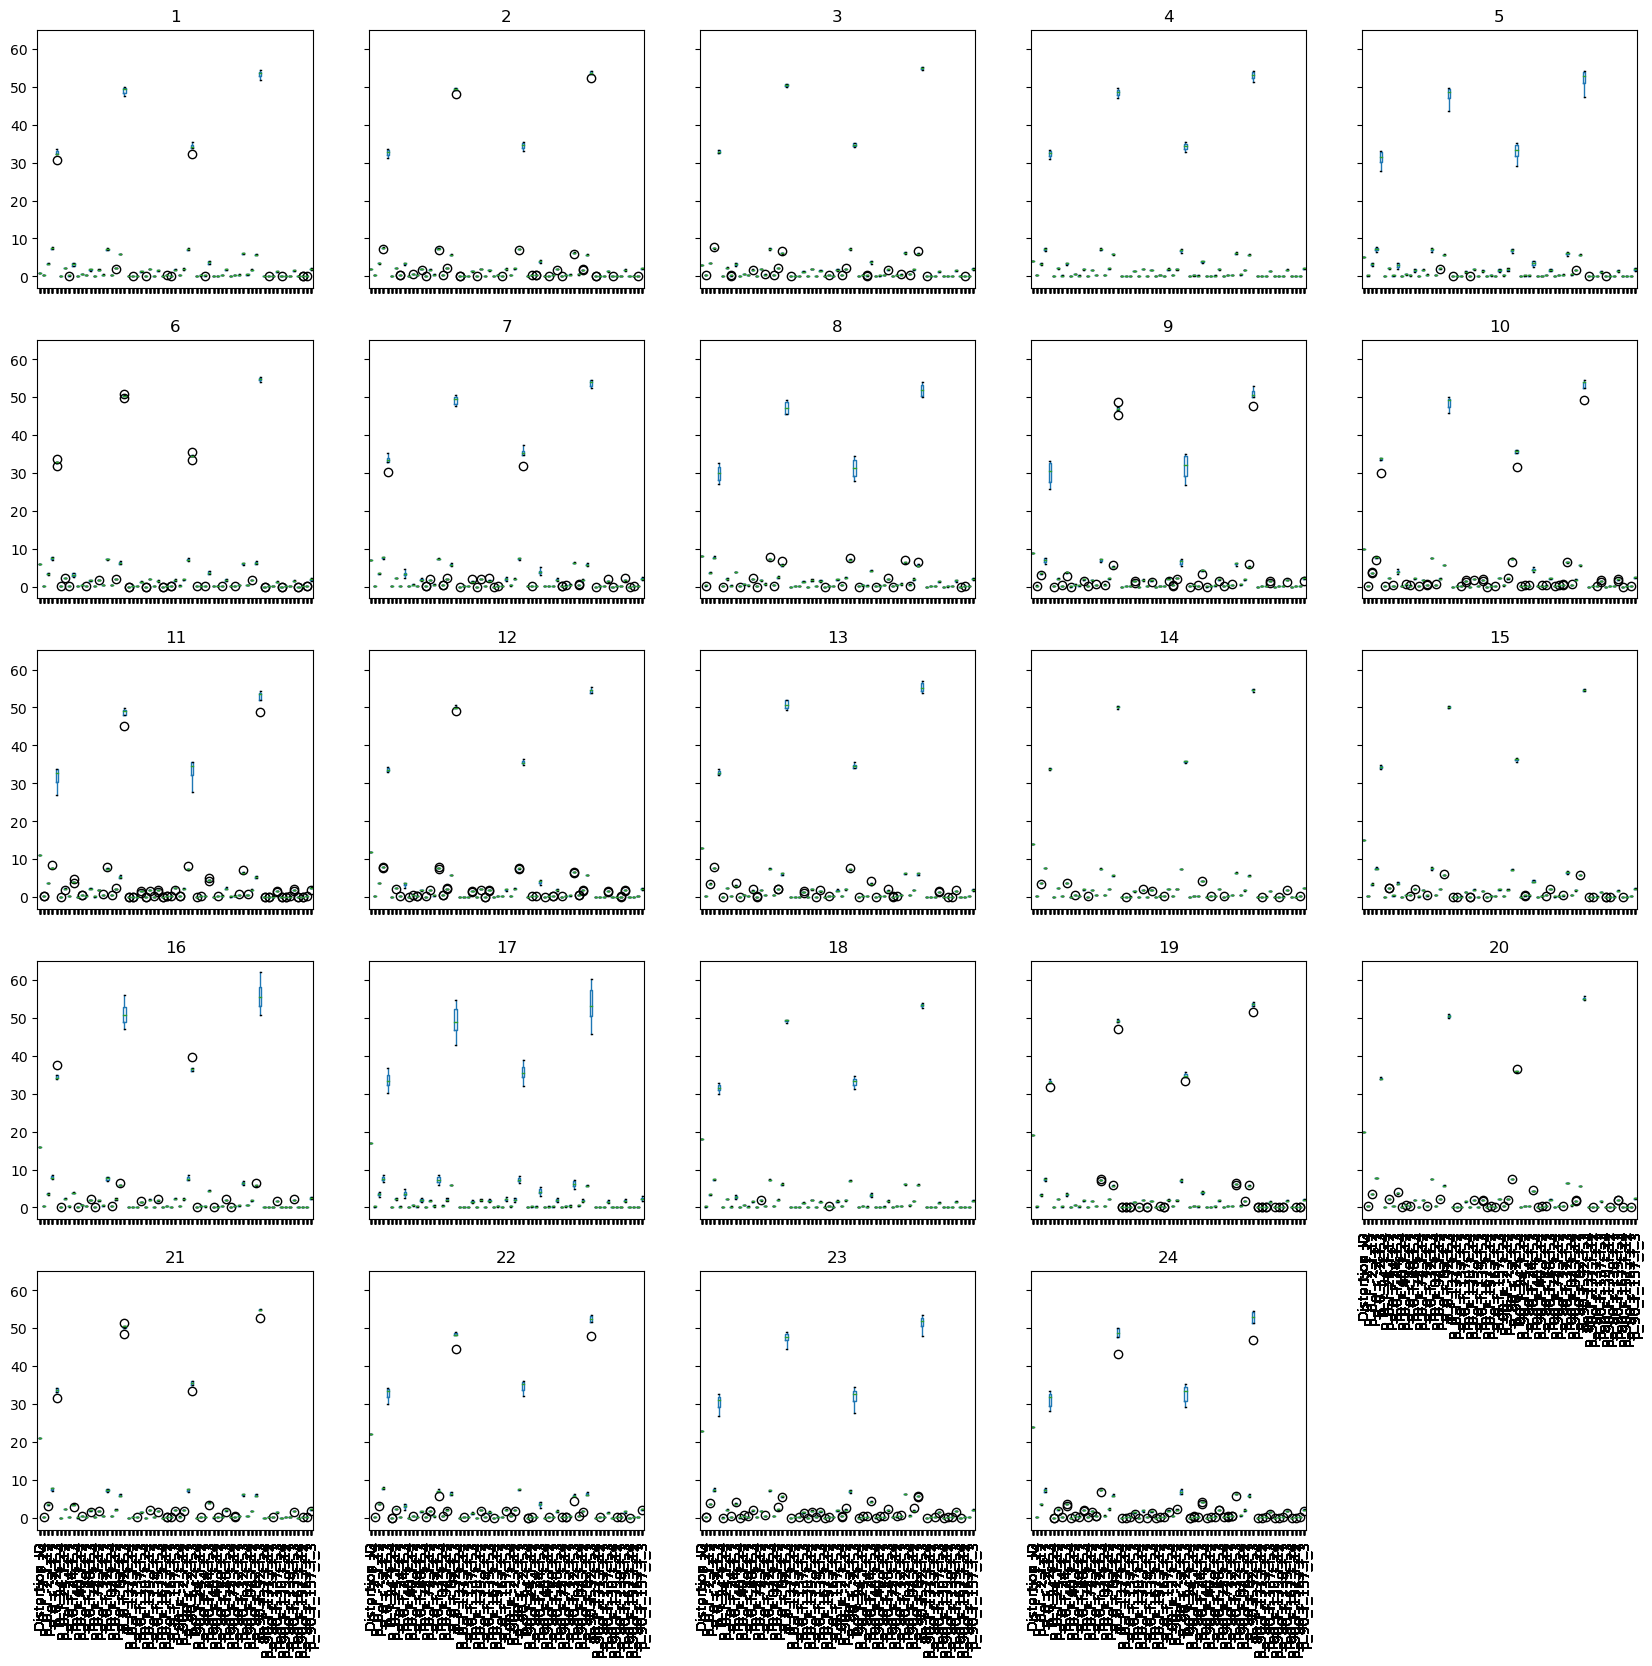

In [195]:
df_dst_o1[df_dst_o1.Reference_ID == 1].drop(columns=["Reference", "Distorted", "MOS", "Reference_ID", "Distortion_Intensity"])\
         .groupby(by="Distortion_ID")\
         .boxplot(figsize=(20,20), sharex=True, sharey=True, rot=90, grid=False)
plt.show()

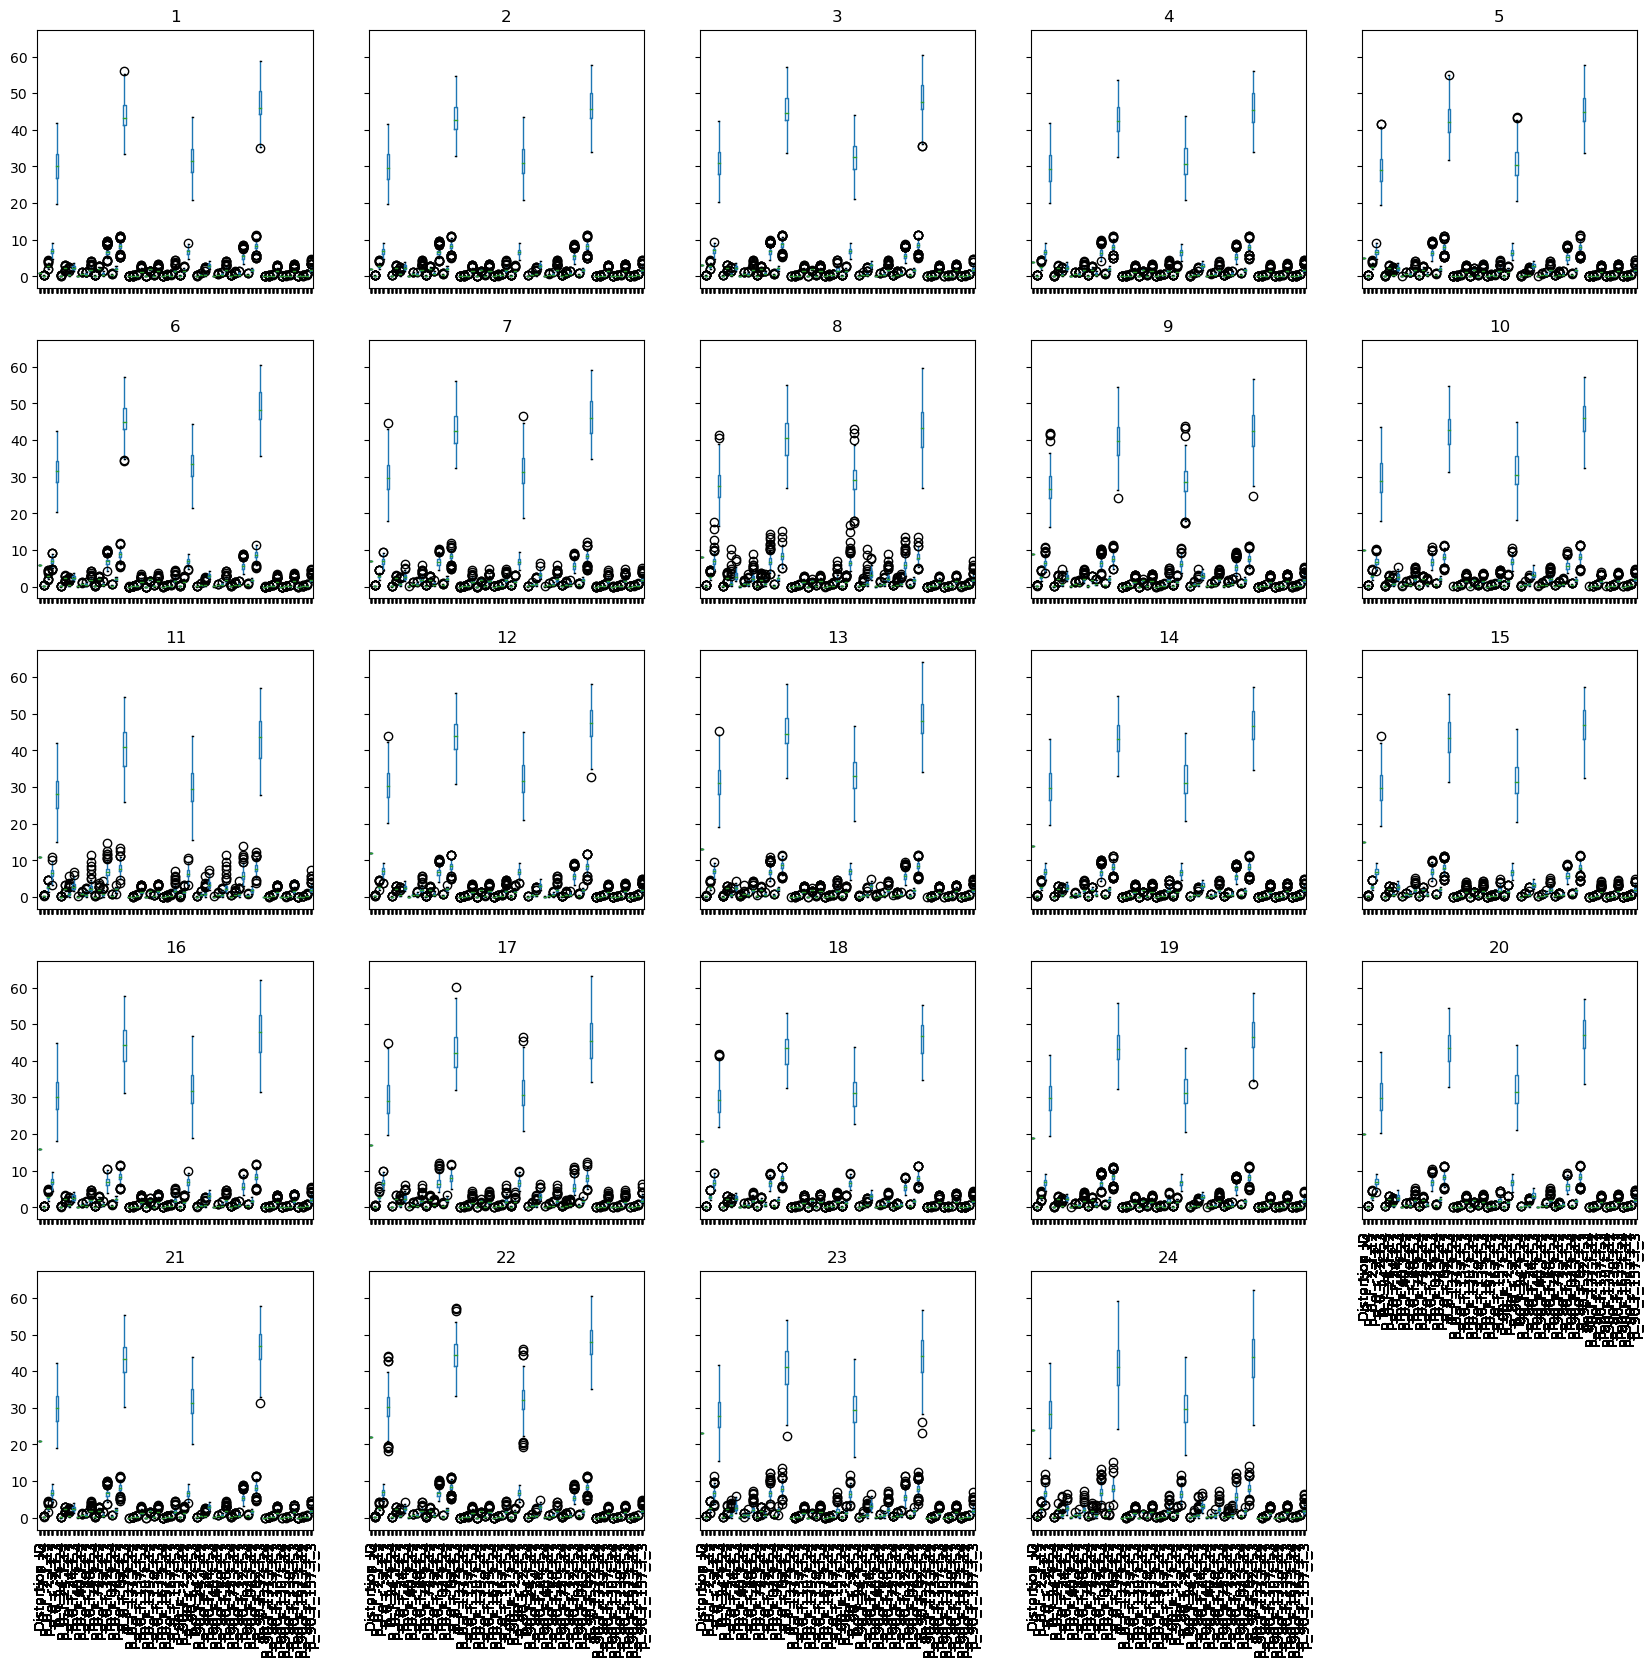

In [ ]:
df_dst_o1.drop(columns=["Reference", "Distorted", "MOS", "Reference_ID", "Distortion_Intensity"])\
         .groupby(by="Distortion_ID")\
         .boxplot(figsize=(20,20), sharex=True, sharey=True, rot=90, grid=False)
plt.show()

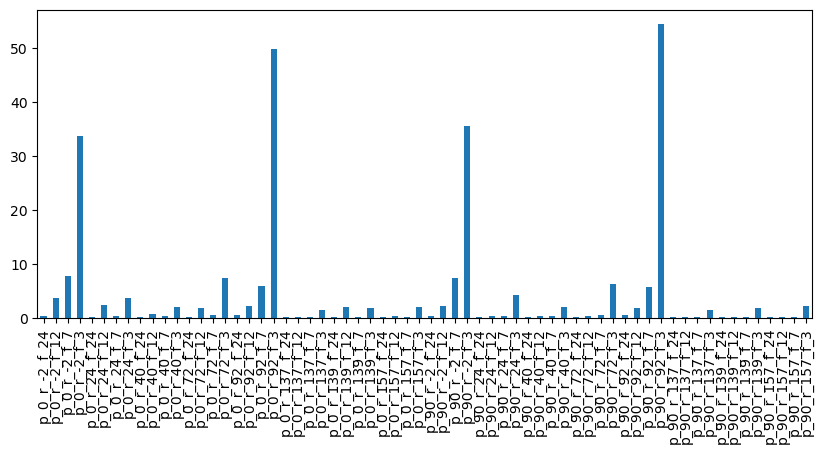

In [179]:
for i, r in df_dst_o1.drop(columns=["Reference", "Distorted", "MOS", "Reference_ID", "Distortion_ID", "Distortion_Intensity"]).iterrows():
    break
r.plot(kind="bar", figsize=(10,4))
plt.show()

In [189]:
kkk = df_dst_o1.drop(columns=["Reference", "Distorted", "MOS", "Distortion_Intensity", "Reference_ID"])\
         .groupby(by=["Distortion_ID"])\
         .mean()
# print(kkk.std())
kkk

,p_0_r_-2_f_24,p_0_r_-2_f_12,p_0_r_-2_f_7,p_0_r_-2_f_3,p_0_r_24_f_24,p_0_r_24_f_12,p_0_r_24_f_7,p_0_r_24_f_3,p_0_r_40_f_24,p_0_r_40_f_12,...,p_90_r_137_f_7,p_90_r_137_f_3,p_90_r_139_f_24,p_90_r_139_f_12,p_90_r_139_f_7,p_90_r_139_f_3,p_90_r_157_f_24,p_90_r_157_f_12,p_90_r_157_f_7,p_90_r_157_f_3
Distortion_ID,,,,,,,,,,,,,,,,,,,,,
1,0.196136,2.799772,6.862593,29.962929,0.101910,2.316442,0.653080,2.448574,0.113140,0.708385,...,0.180516,1.493458,0.026107,0.112562,0.183895,1.705211,0.030356,0.122772,0.261630,1.999855
2,0.199726,2.798326,6.838611,29.641876,0.105714,2.310848,0.694865,2.505444,0.116661,0.721135,...,0.191626,1.520512,0.026230,0.115652,0.193974,1.730403,0.030917,0.129261,0.280460,2.035267
3,0.207194,2.893670,7.044917,30.761444,0.132656,2.415805,0.679801,2.504022,0.155056,0.761440,...,0.190568,1.521631,0.032687,0.124700,0.193484,1.739661,0.037737,0.137299,0.278694,2.044328
4,0.191556,2.720264,6.672819,29.387909,0.090579,2.233371,0.634298,2.441149,0.102150,0.682246,...,0.175824,1.474571,0.022465,0.108144,0.180866,1.684499,0.026813,0.118462,0.263541,1.987245
5,0.190508,2.710901,6.691530,29.099936,0.090823,2.239597,0.597564,2.328324,0.100761,0.670017,...,0.168701,1.423504,0.024828,0.108161,0.173123,1.625114,0.028510,0.115848,0.245132,1.898513
6,0.193501,2.904947,7.104085,31.399244,0.103235,2.403783,0.627406,2.482856,0.117524,0.719081,...,0.192786,1.547412,0.029529,0.125341,0.196745,1.770547,0.033330,0.134149,0.274978,2.054390
7,0.213071,2.876149,6.995212,30.071335,0.120651,2.363323,0.778019,2.739042,0.133616,0.758559,...,0.234145,1.714434,0.029803,0.132148,0.237645,1.924254,0.035720,0.151538,0.347333,2.227822
8,0.182830,2.853949,7.007988,27.493261,0.105991,2.320497,1.256094,3.028199,0.113323,0.846000,...,0.181805,1.422333,0.017680,0.103181,0.184534,1.606504,0.025684,0.144452,0.346130,2.098094
9,0.201026,2.707910,6.577110,27.261513,0.105711,2.240627,0.901129,2.660123,0.109761,0.773576,...,0.203733,1.475724,0.020761,0.112586,0.207502,1.668621,0.028641,0.143152,0.332312,2.079202


In [181]:
# for i, r in kkk.iterrows():
#     r.plot(kind="bar", figsize=(10,4))
#     plt.title(f"Distortion_ID = {i}")
#     plt.show()
    # break

In [182]:
kkk = df_dst_o1.drop(columns=["Reference", "Distorted", "MOS", "Distortion_ID", "Distortion_Intensity"])\
         .groupby(by=["Reference_ID"])\
         .mean()
# print(kkk.std())
kkk

,p_0_r_-2_f_24,p_0_r_-2_f_12,p_0_r_-2_f_7,p_0_r_-2_f_3,p_0_r_24_f_24,p_0_r_24_f_12,p_0_r_24_f_7,p_0_r_24_f_3,p_0_r_40_f_24,p_0_r_40_f_12,...,p_90_r_137_f_7,p_90_r_137_f_3,p_90_r_139_f_24,p_90_r_139_f_12,p_90_r_139_f_7,p_90_r_139_f_3,p_90_r_157_f_24,p_90_r_157_f_12,p_90_r_157_f_7,p_90_r_157_f_3
Reference_ID,,,,,,,,,,,,,,,,,,,,,
1,0.287579,3.508127,7.541353,32.525410,0.068244,2.234487,0.273391,3.460495,0.072242,0.580885,...,0.131366,1.438605,0.019945,0.109786,0.137349,1.727851,0.029115,0.110747,0.179796,2.148303
2,0.166424,1.892269,4.640846,21.047285,0.041389,1.504477,0.409752,1.709777,0.052278,0.429810,...,0.254056,1.630314,0.009001,0.092762,0.235588,1.952166,0.013325,0.102053,0.313353,1.538639
3,0.140284,2.327888,5.262710,25.919228,0.034855,1.977929,0.455921,2.445212,0.043143,0.526243,...,0.231018,1.762007,0.011671,0.111297,0.270928,1.795127,0.017451,0.124424,0.326328,2.604313
4,0.175789,2.084557,4.949595,20.002222,0.109723,2.073766,1.495666,3.670619,0.134225,0.722453,...,0.247002,0.981420,0.014635,0.091902,0.265961,1.119002,0.017607,0.109813,0.253981,1.443624
5,0.227435,3.094154,8.533383,31.765711,0.166747,2.701027,0.827823,2.834567,0.224630,1.207125,...,0.626604,2.800799,0.055878,0.276673,0.524623,3.081417,0.062497,0.355379,0.737767,3.412106
6,0.131416,2.747971,7.001739,30.422638,0.061133,2.271722,0.251462,1.862025,0.094400,0.614538,...,0.140135,1.106317,0.022433,0.108017,0.159248,1.326295,0.023211,0.092038,0.165508,1.477815
7,0.195106,2.945708,5.443358,24.331385,0.126934,2.376613,0.960470,3.569421,0.160830,0.820719,...,0.247877,1.628210,0.026100,0.129300,0.240579,1.769897,0.030963,0.171135,0.330591,1.655951
8,0.426430,3.321070,9.411347,33.021870,0.208822,3.060010,2.793640,2.909963,0.168483,0.826168,...,0.149085,1.164680,0.048619,0.148623,0.163497,1.451829,0.071572,0.203567,0.383321,1.844516
9,0.219567,3.039029,7.150116,29.572496,0.162965,2.464433,0.963444,2.145500,0.141263,0.775931,...,0.221757,1.458194,0.024086,0.115662,0.203816,1.589834,0.036587,0.154666,0.285766,1.972155


In [183]:
# for i, r in kkk.iterrows():
#     r.plot(kind="bar", figsize=(10,4))
#     plt.title(f"Reference_ID = {i}")
#     plt.ylim([0, kkk.max().max()+kkk.max().max()*0.1])
#     plt.show()
    # break

In [184]:
kkk = df_dst_o1.drop(columns=["Reference", "Distorted", "MOS", "Distortion_ID", "Reference_ID"])\
         .groupby(by=["Distortion_Intensity"])\
         .mean()
# print(kkk.std())
kkk

,p_0_r_-2_f_24,p_0_r_-2_f_12,p_0_r_-2_f_7,p_0_r_-2_f_3,p_0_r_24_f_24,p_0_r_24_f_12,p_0_r_24_f_7,p_0_r_24_f_3,p_0_r_40_f_24,p_0_r_40_f_12,...,p_90_r_137_f_7,p_90_r_137_f_3,p_90_r_139_f_24,p_90_r_139_f_12,p_90_r_139_f_7,p_90_r_139_f_3,p_90_r_157_f_24,p_90_r_157_f_12,p_90_r_157_f_7,p_90_r_157_f_3
Distortion_Intensity,,,,,,,,,,,,,,,,,,,,,
1,0.203889,2.849061,6.936282,29.903639,0.108965,2.338612,0.754257,2.659312,0.118911,0.741036,...,0.210663,1.591120,0.025576,0.120282,0.213911,1.803383,0.031244,0.138466,0.311916,2.160140
2,0.204488,2.849498,6.931980,29.825012,0.110577,2.343091,0.764676,2.663805,0.121457,0.747106,...,0.208321,1.585960,0.026036,0.120335,0.210965,1.798496,0.031701,0.139003,0.310789,2.156012
3,0.202063,2.833858,6.907240,29.639944,0.108917,2.336008,0.764726,2.628370,0.120222,0.744350,...,0.198302,1.556771,0.025322,0.117376,0.201256,1.768697,0.031174,0.136328,0.300995,2.127679
4,0.203731,2.832456,6.893154,29.474346,0.111125,2.337626,0.794748,2.648245,0.122033,0.755240,...,0.195504,1.543001,0.025752,0.117468,0.199303,1.751453,0.031729,0.137168,0.302633,2.102018
5,0.194517,2.775664,6.828770,29.202477,0.099251,2.289055,0.788671,2.610886,0.109310,0.723789,...,0.182280,1.484247,0.023563,0.111991,0.186748,1.689685,0.029089,0.128882,0.288192,2.039133


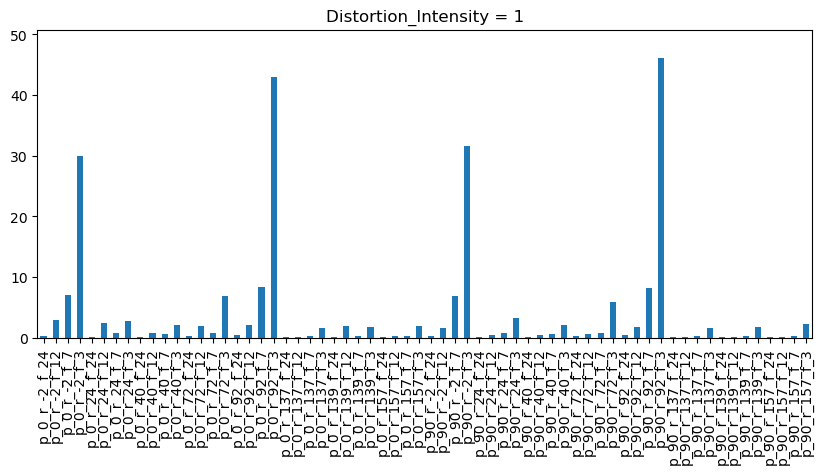

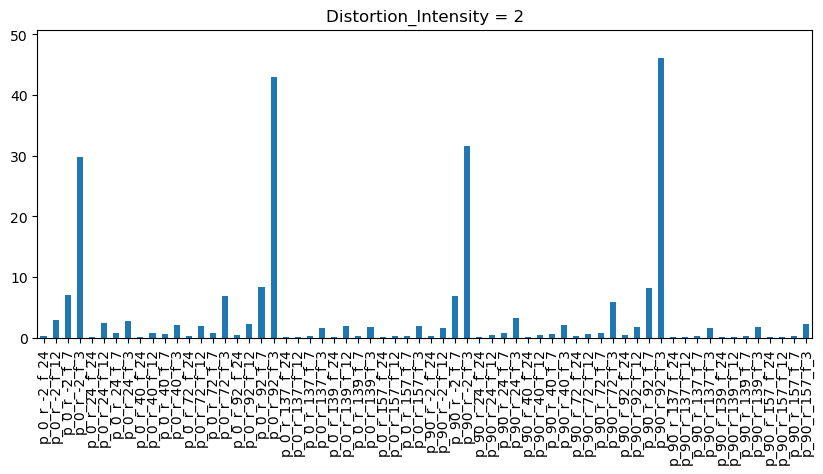

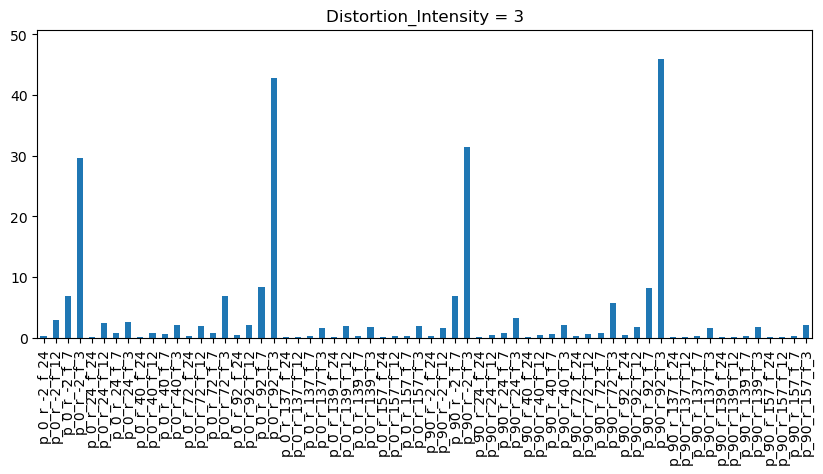

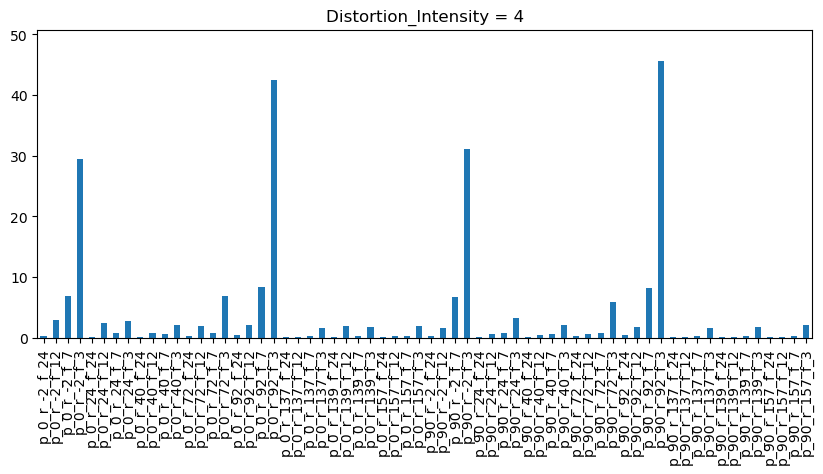

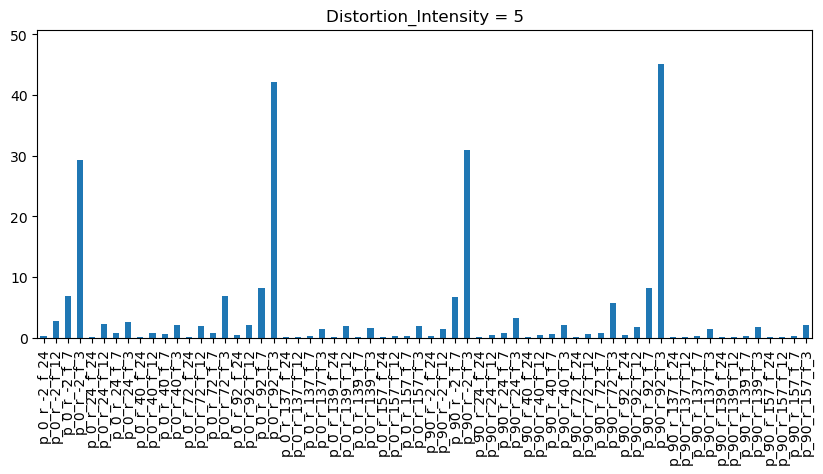

In [185]:
for i, r in kkk.iterrows():
    r.plot(kind="bar", figsize=(10,4))
    plt.title(f"Distortion_Intensity = {i}")
    plt.ylim([0, kkk.max().max()+kkk.max().max()*0.1])
    plt.show()
    # break

In [186]:
kkk = df_dst_o1.drop(columns=["Reference", "Distorted", "MOS"])\
         .groupby(by=["Distortion_ID", "Distortion_Intensity", "Reference_ID"])\
         .mean()
# print(kkk.std())
kkk

p_0_r_-2_f_24  p_0_r_-2_f_12   
Distortion_ID Distortion_Intensity Reference_ID                                 
1             1                    1                  0.294233       3.531512  \
                                   2                  0.168057       1.925857   
                                   3                  0.141537       2.319029   
                                   4                  0.177591       2.084357   
                                   5                  0.226946       3.119115   
...                                                        ...            ...   
24            5                    21                 0.135339       2.383739   
                                   22                 0.084371       2.014907   
                                   23                 0.121835       2.110733   
                                   24                 0.155520       2.474448   
                                   25                 0.470941       4.457782   

                                                 p_0_r_-2_f_7  p_0_r_-2_f_3   
Distortion_ID Distortion_Intensity Reference_ID                               
1             1                    1                 7.697433     33.553158  \
                                   2                 4.790240     21.220055   
                                   3                 5.196662     26.172003   
                                   4                 4.861827     19.893822   
                                   5                 8.553078     32.019279   
...                                                       ...           ...   
24            5                    21                6.203380     27.872314   
                                   22                5.908494     25.698532   
                                   23                7.064597     23.144451   
                                   24                7.044736     24.862808   
                                   25                8.580318     39.901161   

                                                 p_0_r_24_f_24  p_0_r_24_f_12   
Distortion_ID Distortion_Intensity Reference_ID                                 
1             1                    1                  0.064564       2.258268  \
                                   2                  0.039987       1.516448   
                                   3                  0.029060       1.980313   
                                   4                  0.119225       2.104684   
                                   5                  0.165093       2.703471   
...                                                        ...            ...   
24            5                    21                 0.041440       2.261791   
                                   22                 0.005295       1.592701   
                                   23                 0.009011       1.865759   
                                   24                 0.015963       1.724064   
                                   25                 0.148355       2.669803   

                                                 p_0_r_24_f_7  p_0_r_24_f_3   
Distortion_ID Distortion_Intensity Reference_ID                               
1             1                    1                 0.260744      3.609977  \
                                   2                 0.433901      1.695521   
                                   3                 0.391450      2.487447   
                                   4                 1.515869      3.716028   
                                   5                 0.798225      2.738953   
...                                                       ...           ...   
24            5                    21                0.911150      2.472163   
                                   22                0.371529      3.571041   
                                   23                1.256750      5.354289   
                                   24       

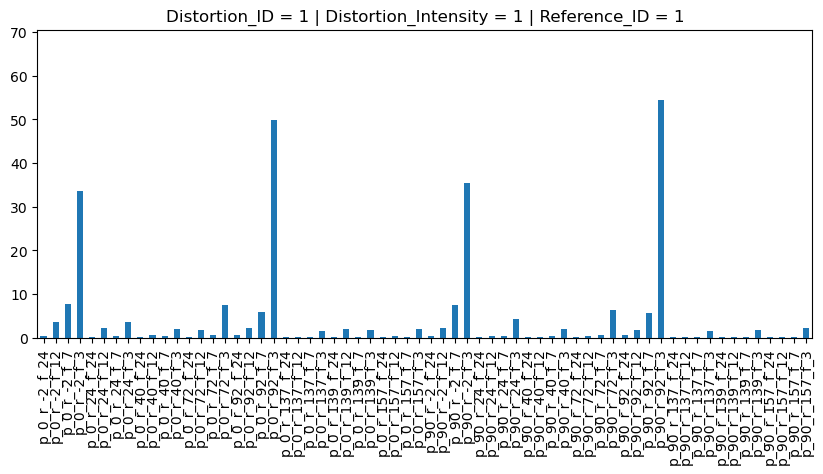

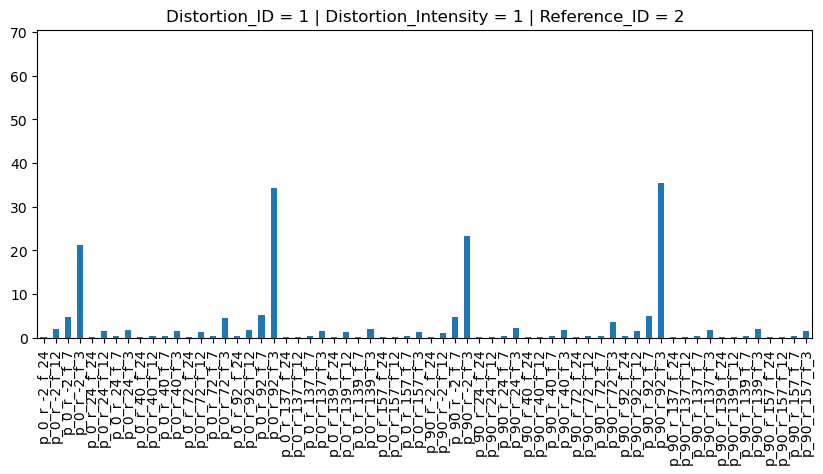

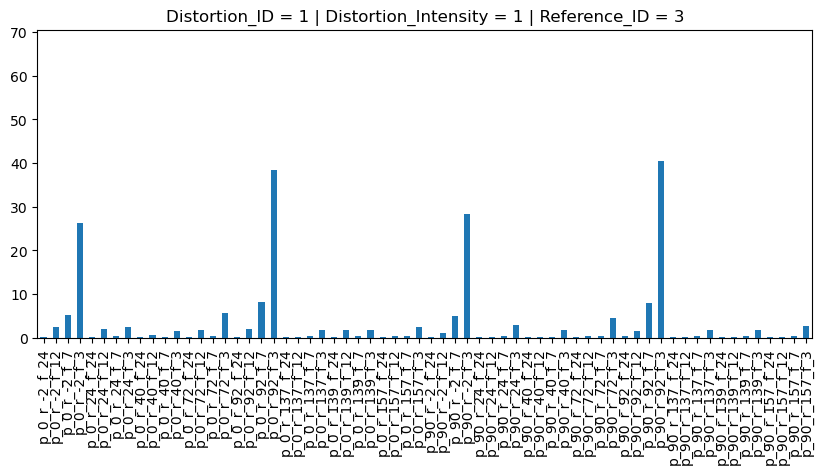

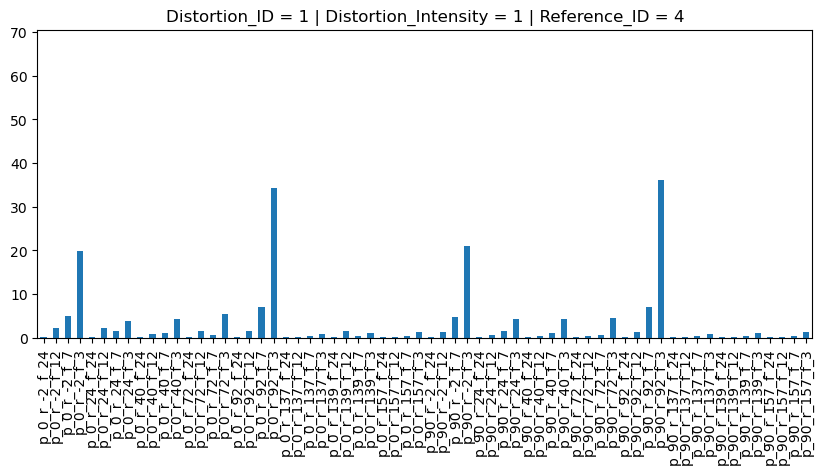

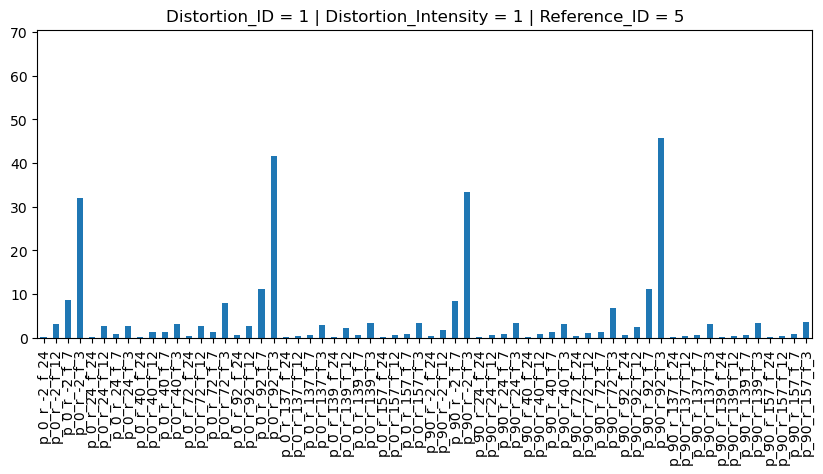

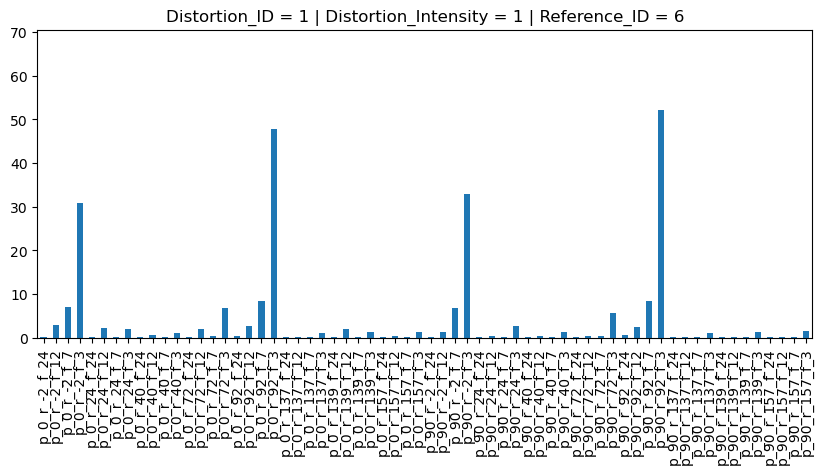

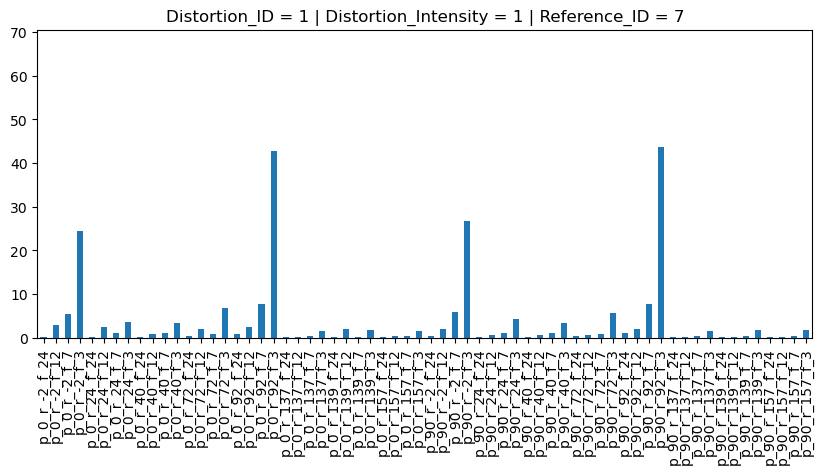

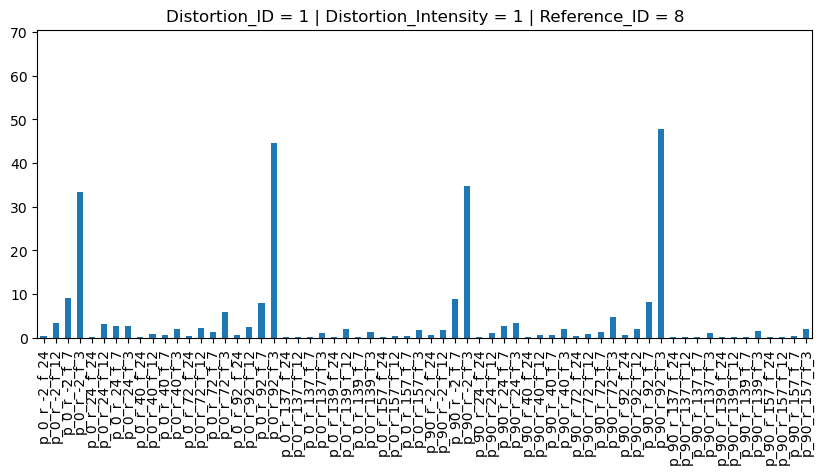

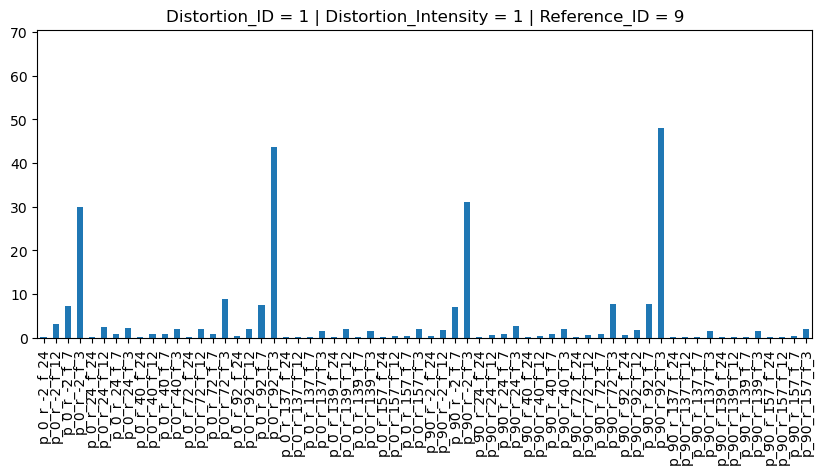

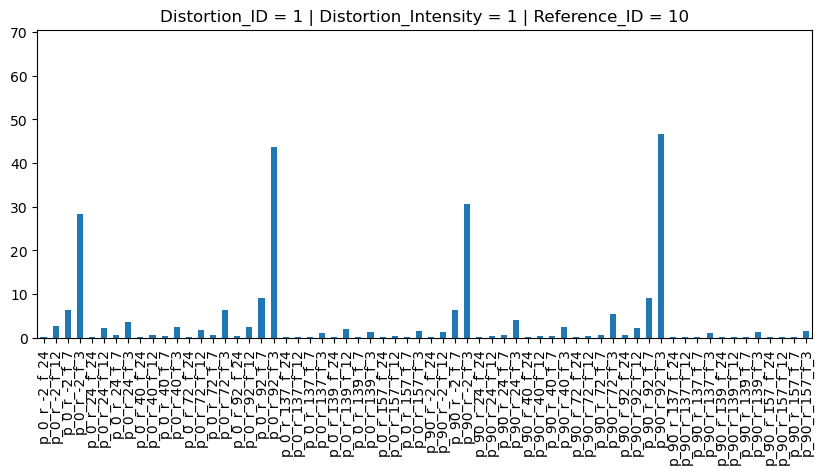

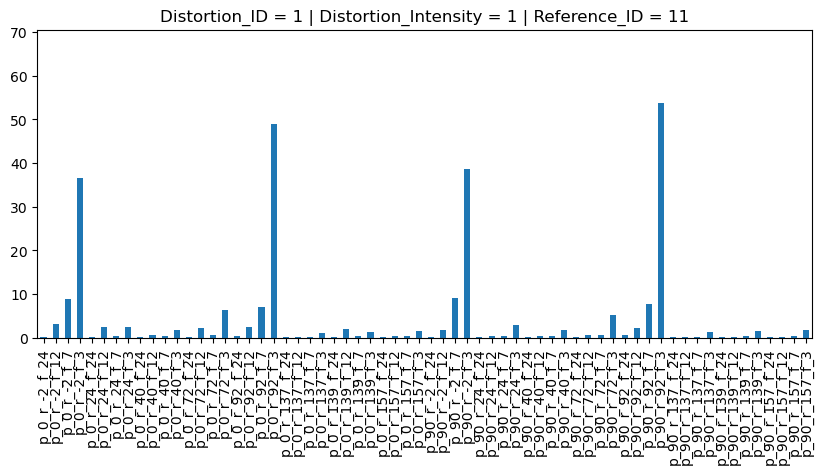

In [187]:
j = 0
for i, r in kkk.iterrows():
    if j > 10: break
    r.plot(kind="bar", figsize=(10,4))
    plt.title(f"Distortion_ID = {i[0]} | Distortion_Intensity = {i[1]} | Reference_ID = {i[2]}")
    plt.ylim([0, kkk.max().max()+kkk.max().max()*0.1])
    plt.show()
    j += 1

In [130]:
import seaborn as sns

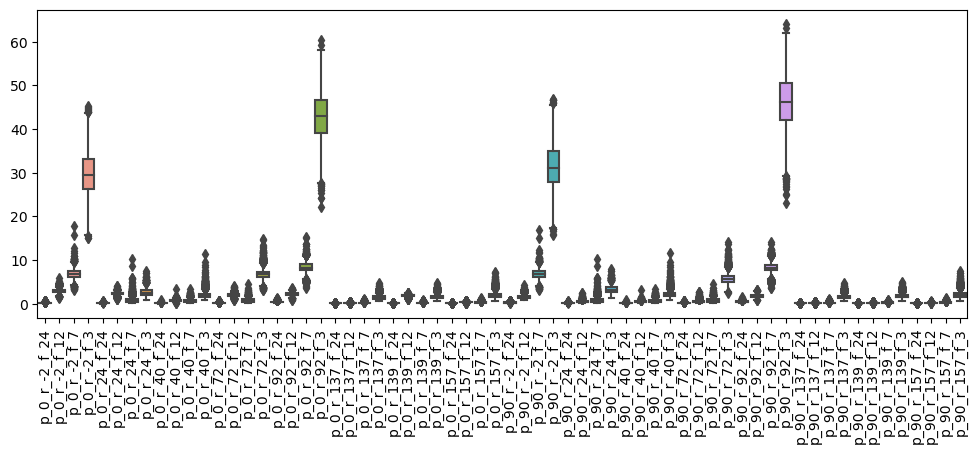

In [188]:
plt.figure(figsize=(12,4))
sns.boxplot(data=kkk)
plt.xticks(rotation=90)
plt.show()

In [36]:
idxs_outputs_0 = (-outputs_0).argsort(axis=1)
idxs_outputs_1 = (-outputs_1).argsort(axis=1)

In [ ]:
params_sorted

In [37]:
params[idxs_outputs_1[0]]

array([{'phase': 0.0, 'rot': 23.840329628086163, 'freq': 12.327524},
       {'phase': 0.0, 'rot': 92.2080865499274, 'freq': 12.327524},
       {'phase': 90.0, 'rot': 92.2080865499274, 'freq': 12.327524},
       {'phase': 0.0, 'rot': 72.18311937523058, 'freq': 12.327524},
       {'phase': 90.0, 'rot': 139.296162008804, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': 139.296162008804, 'freq': 3.1530545},
       {'phase': 90.0, 'rot': 92.2080865499274, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': -2.060268506526401, 'freq': 12.327524},
       {'phase': 90.0, 'rot': 23.840329628086163, 'freq': 12.327524},
       {'phase': 90.0, 'rot': -2.060268506526401, 'freq': 12.327524},
       {'phase': 0.0, 'rot': 92.2080865499274, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': -2.060268506526401, 'freq': 6.715935},
       {'phase': 90.0, 'rot': 156.9166157277112, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': 156.9166157277112, 'freq': 3.1530545},
       {'phase': 0.0, 'rot': 72.183119375230

Obtain all the distances as well:

In [27]:
%%time
dists = []
for batch in tqdm(dst_rdy.as_numpy_iterator()):
    dist = compute_distance(state=state, batch=batch)
    dists.extend(dist)
    # break

0it [00:00, ?it/s]

CPU times: user 1min 27s, sys: 8.98 s, total: 1min 36s
Wall time: 23.5 s


In [37]:
df["OA"] = dists_oa
df["OB"] = dists_ob
df["P"] = (df["OA"] <= df["OB"])*1.
# df.to_csv("results.csv", index=False)

In [7]:
df.head()

,O,A,B,T,OA,OB,P
0,be43cc0f85e942d3fdc665762c605290.png,7254fe35836ce43f2074a279cf701e83.png,2a99c0f0693141dbb89aabff89c76375.png,1,143.65196,114.59282,0.0
1,be43cc0f85e942d3fdc665762c605290.png,2a99c0f0693141dbb89aabff89c76375.png,ea17517b144b307fe94126f4fd47f9a0.png,1,114.59282,84.52186,0.0
2,be43cc0f85e942d3fdc665762c605290.png,3edf95bdb6437e2a9e96253fe4c3d05c.png,2a99c0f0693141dbb89aabff89c76375.png,0,106.423035,114.59282,1.0
3,be43cc0f85e942d3fdc665762c605290.png,ea17517b144b307fe94126f4fd47f9a0.png,3edf95bdb6437e2a9e96253fe4c3d05c.png,0,84.52186,106.423035,1.0
4,be43cc0f85e942d3fdc665762c605290.png,bcdfbb5743e627161904770a7df87ab3.png,3edf95bdb6437e2a9e96253fe4c3d05c.png,1,101.336006,106.423035,1.0


In [8]:
accuracy = df.P.sum() / len(df)
accuracy

0.507088122605364

In [46]:
# wandb.log({"Pred_Distances": wandb.Table(dataframe=df)})
# wandb.run.summary["Accuracy"] = accuracy

Error: You must call wandb.init() before wandb.log()

In [45]:
wandb.finish()

Accuracy,0.50709
trainable_parameters,4716
